In [1]:
!mkdir -p images
!curl https://cdn.pixabay.com/photo/2016/05/18/00/27/franz-marc-1399594_960_720.jpg > images/style.jpg
!curl https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/Golden_tabby_and_white_kitten_n01.jpg/1280px-Golden_tabby_and_white_kitten_n01.jpg > images/image.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  289k  100  289k    0     0   447k      0 --:--:-- --:--:-- --:--:--  448k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 58  131k   58 79161    0     0   163k      0 --:--:-- --:--:-- --:--:--  163k
100  131k  100  131k    0     0   255k      0 --:--:-- --:--:-- --:--:--  255k


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
import IPython.display as display

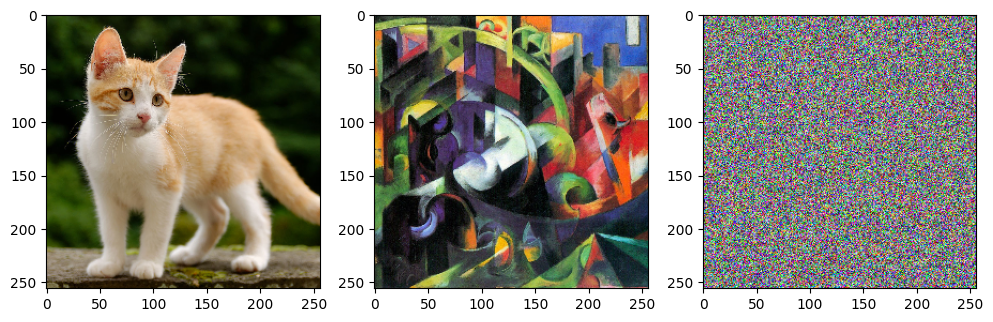

In [6]:
image_size = 256
def load_image(fn):
    x = cv2.imread(fn)
    return cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

img_style = load_image('images/style.jpg')
img_content = load_image('images/image.jpg')
img_content = img_content[:,200:200+857,:]
img_content = cv2.resize(img_content, (image_size, image_size))
img_style = img_style[:, 200:200+671,:]
img_style = cv2.resize(img_style, (image_size, image_size))

img_result = np.random.uniform(size = (image_size, image_size, 3))

matplotlib.rcParams['figure.figsize'] = (12, 12)
matplotlib.rcParams['axes.grid'] = False

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img_content)
ax[1].imshow(img_style)
ax[2].imshow((255*img_result).astype(int))
plt.show()

In [7]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
vgg.trainable = False

In [8]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [9]:
def layer_extractor(layers):
    outputs = [vgg.get_layer(x).output for x in layers]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [11]:
content_layers = ['block4_conv2']
content_extractor = layer_extractor(content_layers)

content_target = content_extractor(preprocess_input(tf.expand_dims(img_content, axis = 0)))

def content_loss(img):
    z = content_extractor(preprocess_input(tf.expand_dims(255*img, axis = 0)))
    return 0.5*tf.reduce_sum((z-content_target)**2)

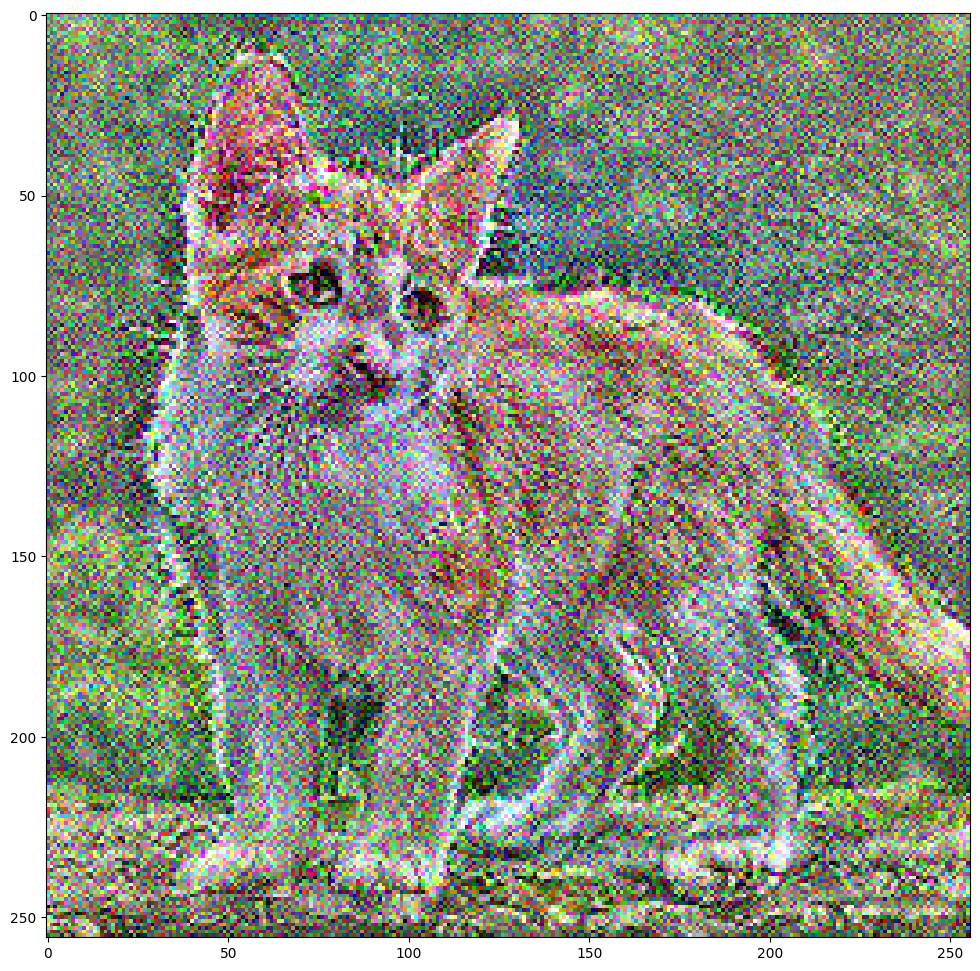

In [14]:
img = tf.Variable(img_result)
opt = tf.optimizers.Adam(learning_rate=0.002, beta_1=0.99, epsilon=1e-1)

clip  = lambda x : tf.clip_by_value(x, clip_value_min=0, clip_value_max=1)

def optimize(img, loss_fn):
    with tf.GradientTape() as tape:
        loss = loss_fn(img)
    grad = tape.gradient(loss, img)
    opt.apply_gradients([(grad, img)])

def train(img, loss_fn, epochs = 10, steps_per_epoch = 100):
    for _ in range(epochs):
        display.clear_output(wait=True)
        plt.imshow((255*clip(img)).numpy().astype(int))
        plt.show()
        for _ in range(steps_per_epoch):
            optimize(img, loss_fn = loss_fn)

train(img, content_loss)

## Style Loss

In [16]:
def gram_matrix(x):
    result = tf.linalg.einsum('bijc,bijd->bcd', x, x)
    input_shape = tf.shape(x)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']

def style_extractor(img):
    return [gram_matrix(x) for x in layer_extractor(style_layers)(img)]

style_target = style_extractor(preprocess_input(tf.expand_dims(img_style, axis = 0)))

def style_loss(img):
    z = style_extractor(preprocess_input(tf.expand_dims(255*img, axis = 0)))
    loss = tf.add_n([tf.reduce_mean((x-target)**2) for x, target in zip(z, style_target)])

    return loss / len(style_layers)

## Putting it all together

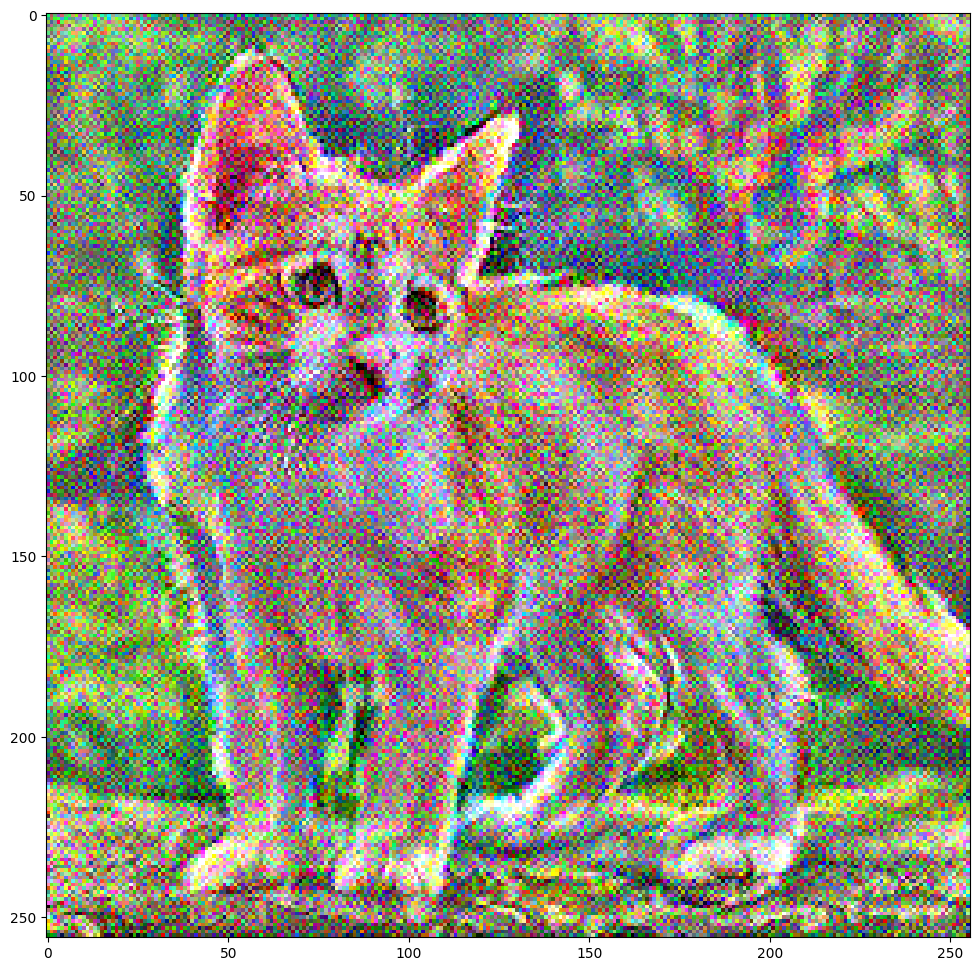

In [17]:
def total_loss(img):
    return 2*content_loss(img) + style_loss(img)
img.assign(img_result)

train(img, loss_fn=total_loss)

## Add variation loss

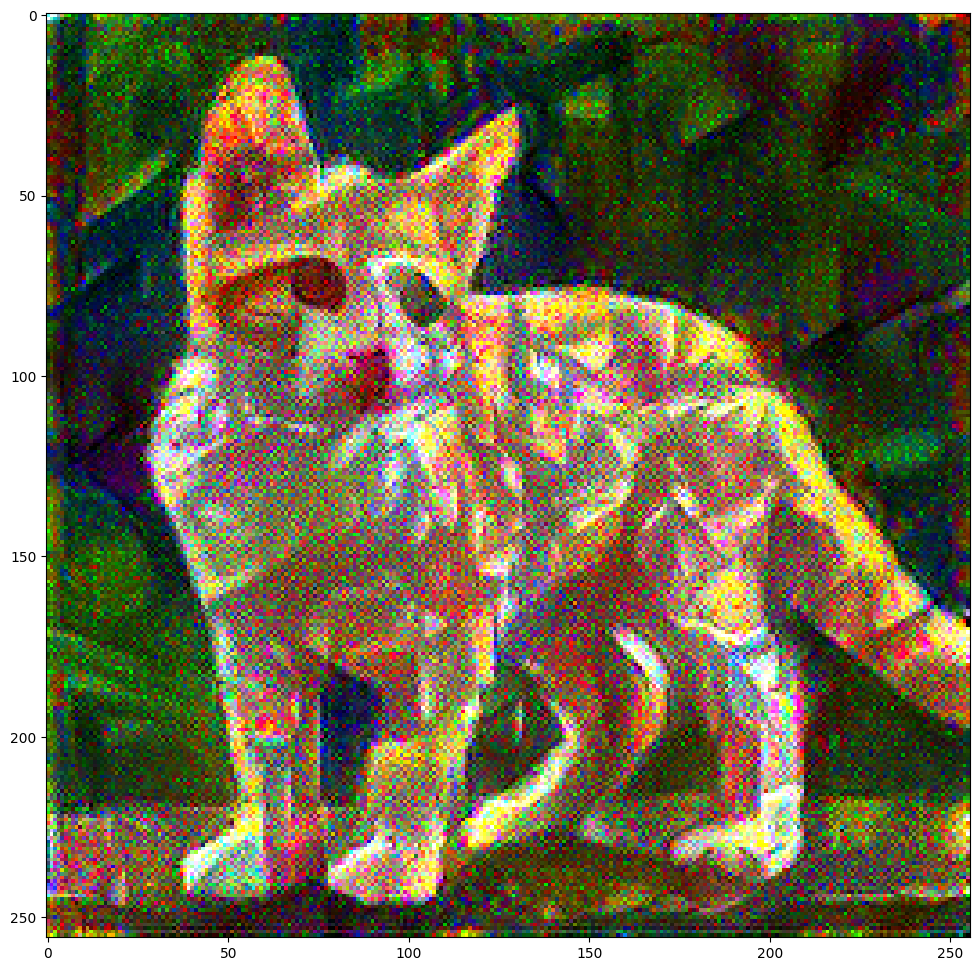

In [18]:
def variation_loss(img):
    img = tf.cast(img, tf.float32)
    x_var = img[:, 1:, :] - img[:, :-1, :]
    y_var = img[1:, :, :] - img[:-1, :, ]
    return tf.reduce_sum(tf.abs(x_var)) + tf.reduce_sum(tf.abs(y_var))

def total_loss_var(img):
    return content_loss(img)+150*style_loss(img)+30*variation_loss(img)

img.assign(clip(np.random.normal(-0.3,0.3,size=img_content.shape)+img_content/255.0))

train(img, loss_fn=total_loss_var)

In [20]:
cv2.imwrite('result.jpg',(img.numpy()[:,:,::-1]*255))

True